In [1]:
import ipywidgets as ipw
from IPython.display import display
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import json

from stochastic_models import model_sir
from stochastic_tests import Test
import sim_lib

t_fin = 10.0
num_steps = 200
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   trials=[100, 1000, 10000], 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)])

beta_mean = 2E-6
beta_stdevs = [x * beta_mean for x in [0.001, 0.01, 0.1, 0.2, 0.3]]

_ = sim_lib.start_pool()

In [2]:
tests = [Test(model=model_sir({'beta': ('norm', (beta_mean, bs))}), stochastic=False, **test_kwargs) for bs in beta_stdevs]

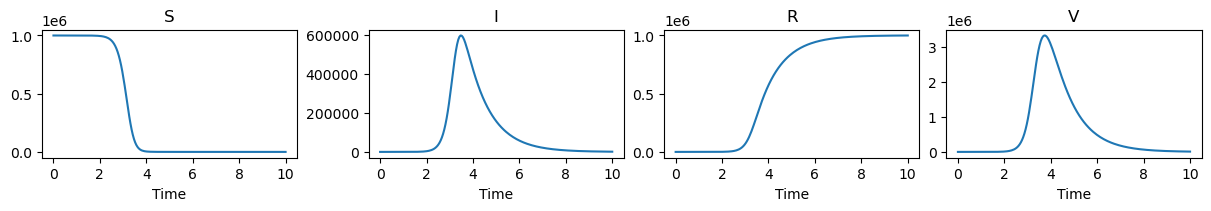

In [3]:
[test.execute_deterministic() for test in tests]
_ = tests[0].plot_results_deterministic()

In [4]:
label, label_header, out = ipw.Label(), ipw.Label(), ipw.Output()
display(out)
with out:
    display(label_header)
    display(label)

for i, test in enumerate(tests):
    label_header.value = f'Test {i+1}...'
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

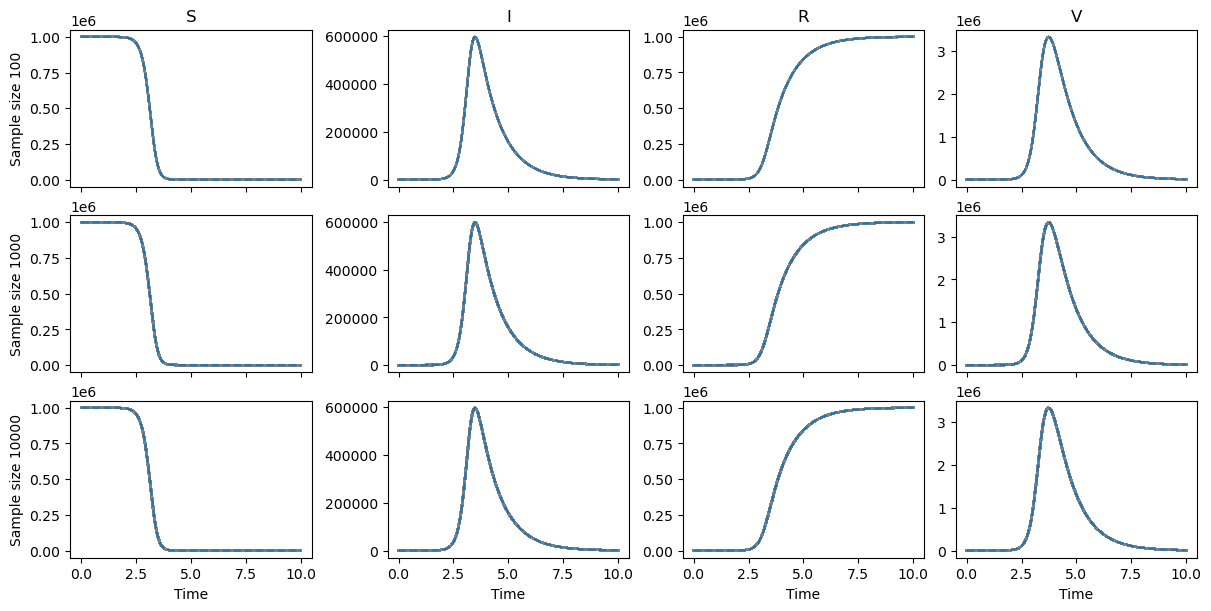

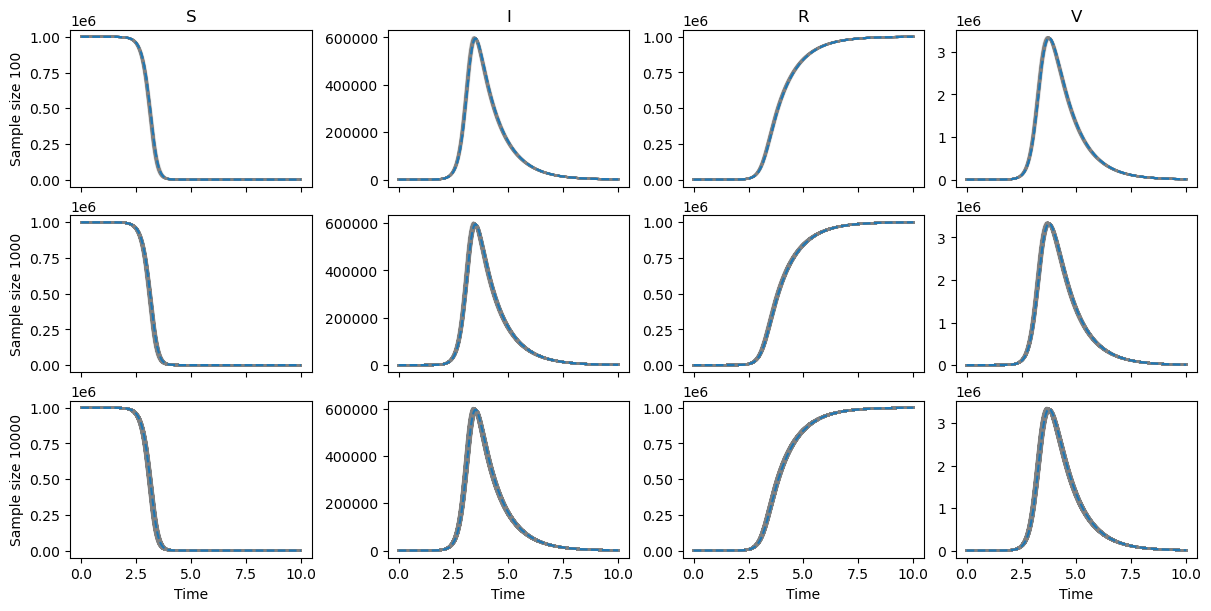

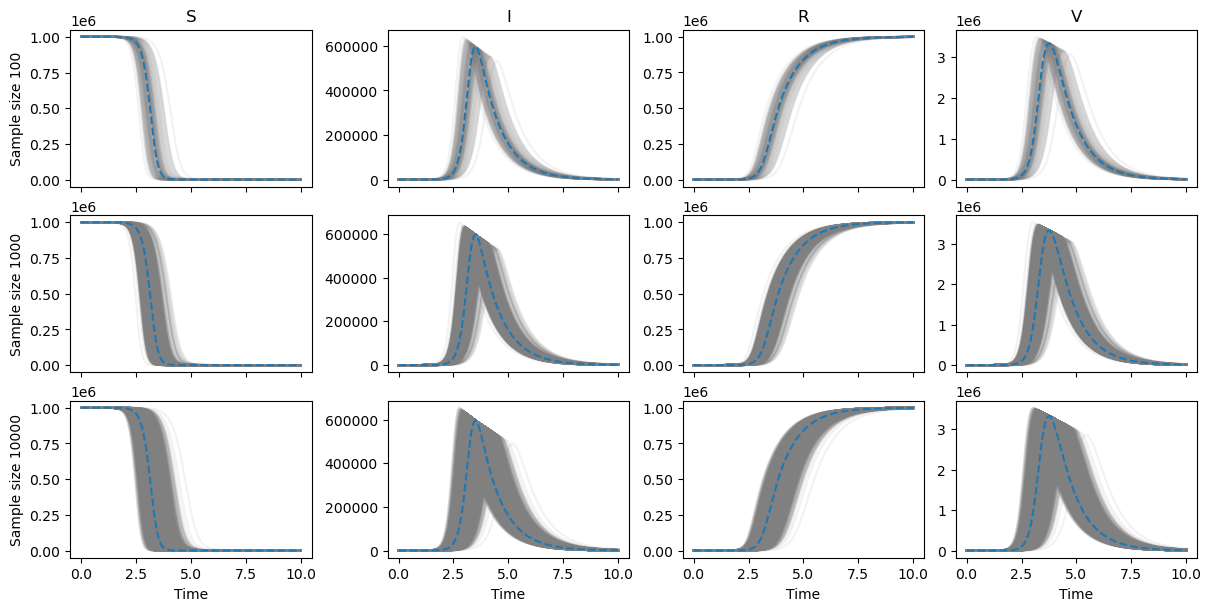

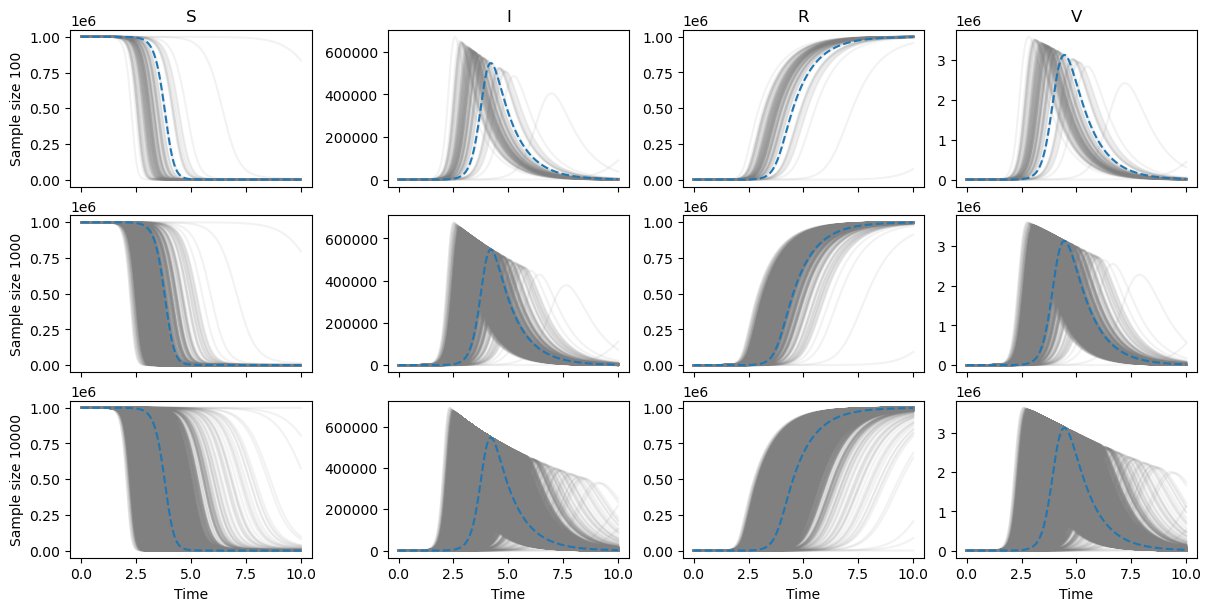

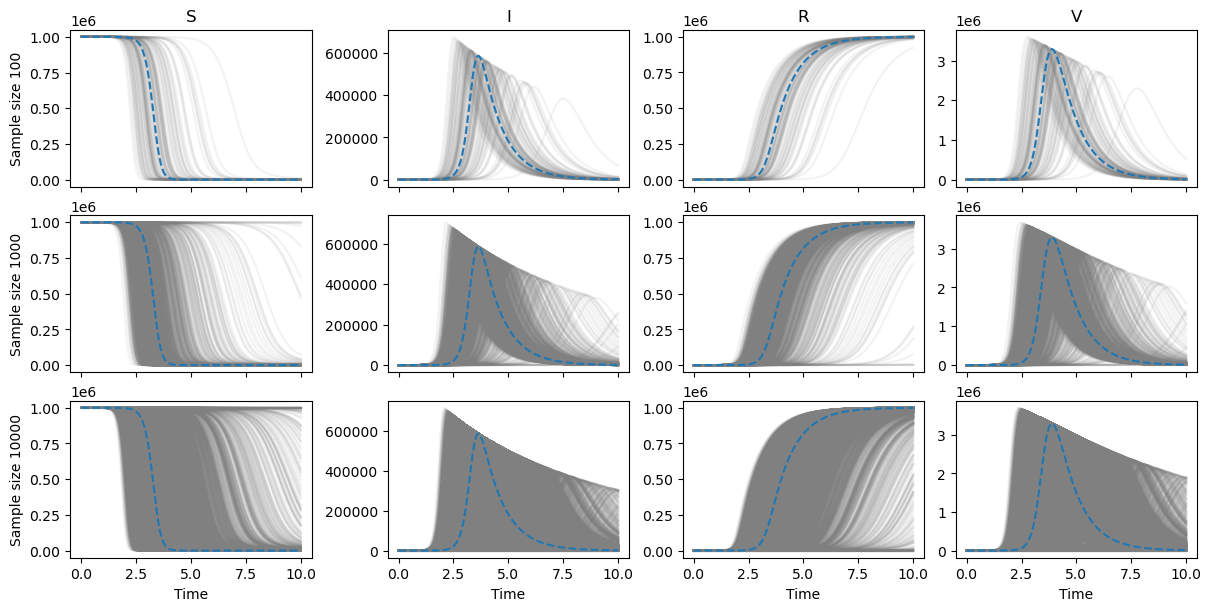

In [5]:
_ = [test.plot_results_stochastic() for test in tests]

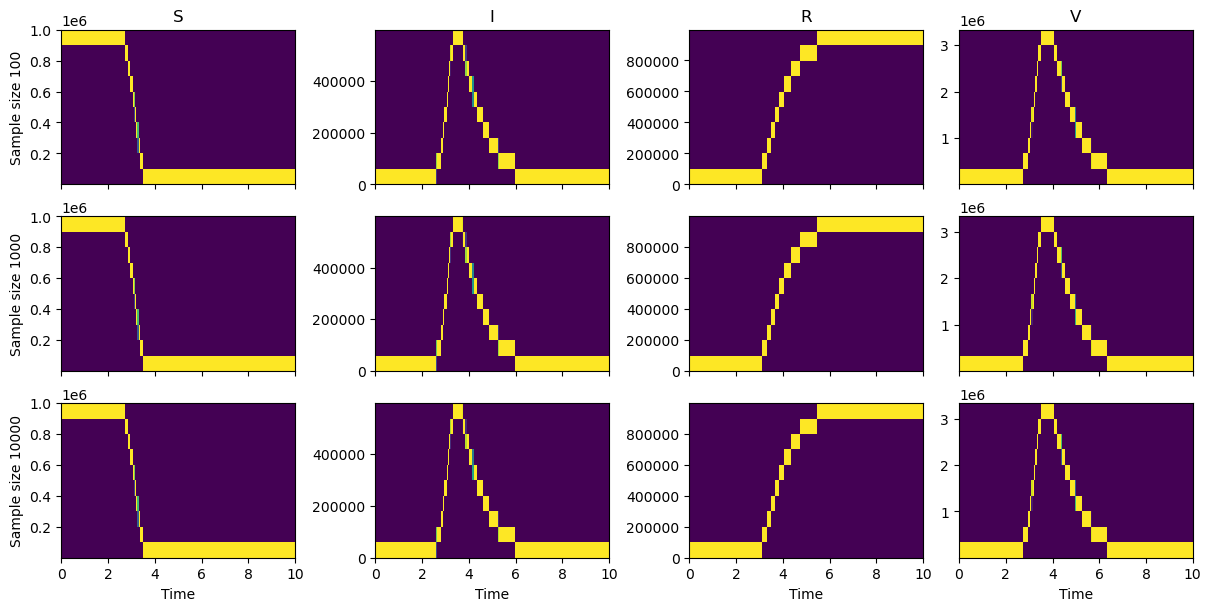

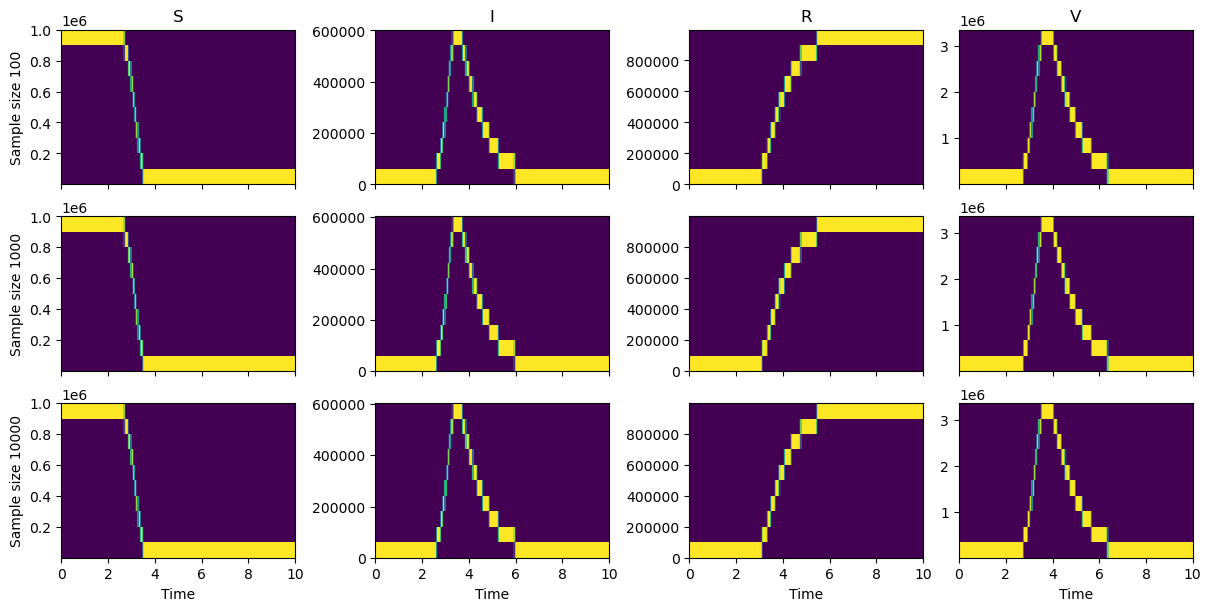

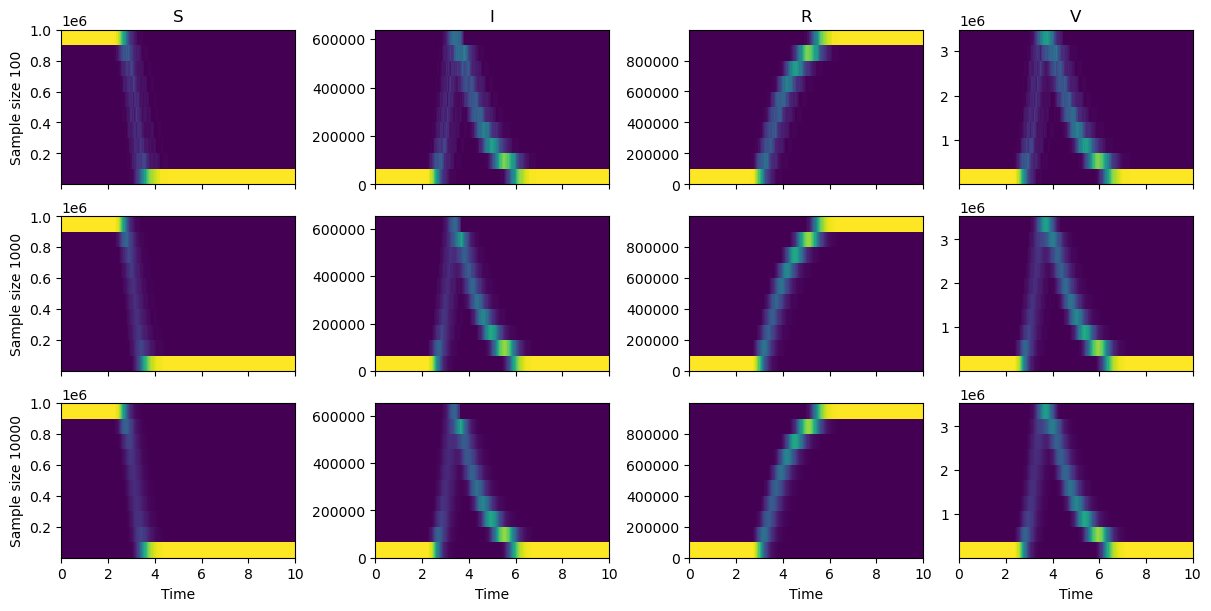

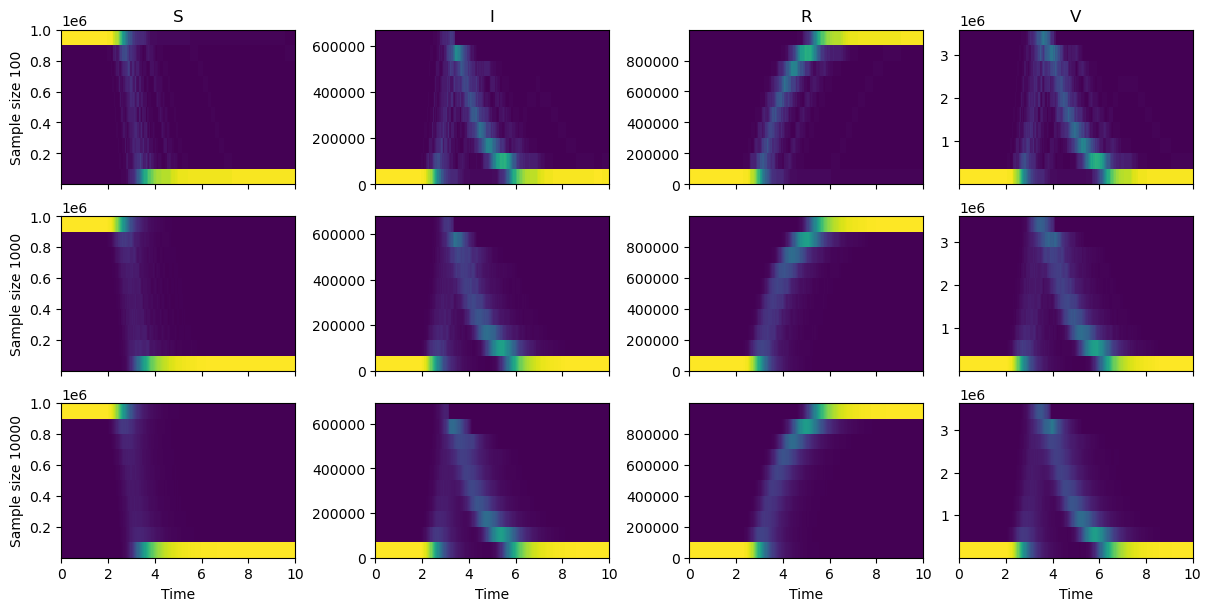

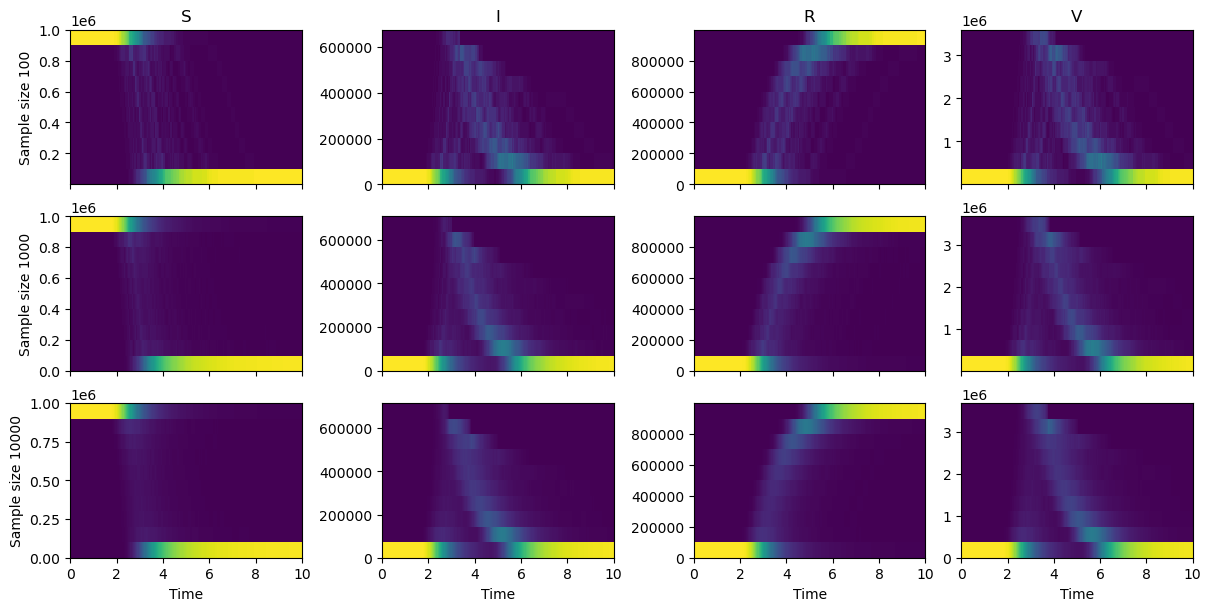

In [6]:
_ = [test.plot_distributions() for test in tests]

In [7]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)


for i, test in enumerate(tests):
    label.value = f'Test: {i+1}... '

    label.value += 'Finding ECFs... '
    test.find_ecfs()
    label.value += 'Finding differences... '
    test.measure_ecf_diffs()
    label.value += 'Testing samples... '
    test.test_sampling(err_thresh=1E-3)
    label.value += 'Generating fits... '
    test.generate_ecf_sampling_fits()
_ = out.clear_output()

Output()

/home/timothy.sego/PycharmProjects/ssr_project_2024/code/stochastic_repro.py:994: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


Show sensitivity to parameter variance.

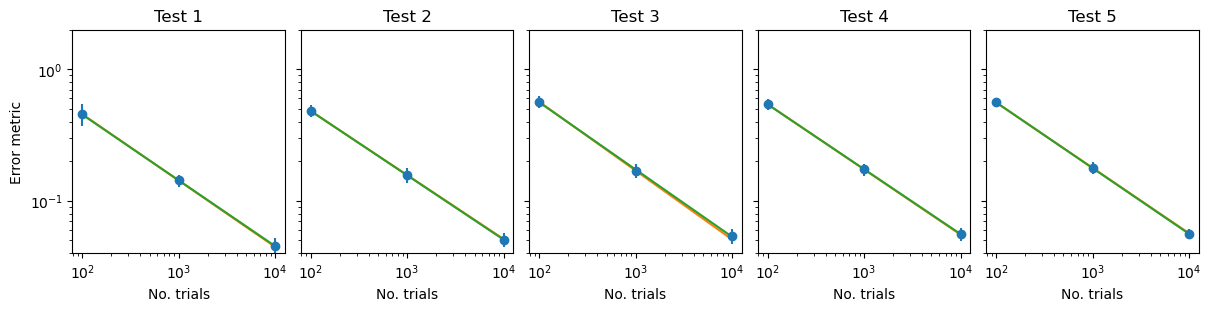

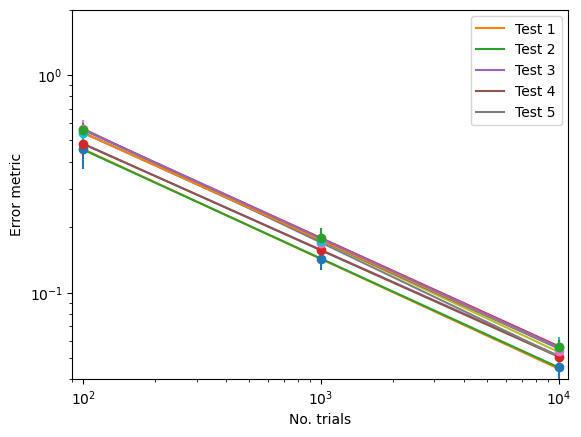

In [8]:
def plot_ecf_sampling(test, ax):
    avg = np.asarray([test.ecf_sampling[t][0] for t in test.trials], dtype=float)
    std = np.asarray([test.ecf_sampling[t][1] for t in test.trials], dtype=float)
    ax.errorbar(test.trials, avg, yerr=std, marker='o', linestyle='none')
    ax.set_xlabel('No. trials')
    ax.set_xscale('log')
    ax.set_yscale('log')

    return ax


fig, axs = plt.subplots(1, len(tests), figsize=(12.0, 3.0), layout='compressed', sharey=True)

for i, test in enumerate(tests):
    _, ax = test.plot_ecf_sampling_fits((fig, plot_ecf_sampling(test, axs[i])))
    ax.set_title(f'Test {i+1}')
    ax.set_ylim(4E-2, 2.0)
_ = axs[0].set_ylabel('Error metric')

fig, axs = plt.subplots(1, 1)
for test in tests:
    test.plot_ecf_sampling_fits((fig, plot_ecf_sampling(test, axs)))
axs.set_xlim(min(tests[0].trials) * 0.9, max(tests[1].trials) * 1.1)
axs.set_ylim(4E-2, 2.0)
axs.legend(labels=[f'Test {i+1}' for i in range(len(tests))])
_ = axs.set_ylabel('Error metric')

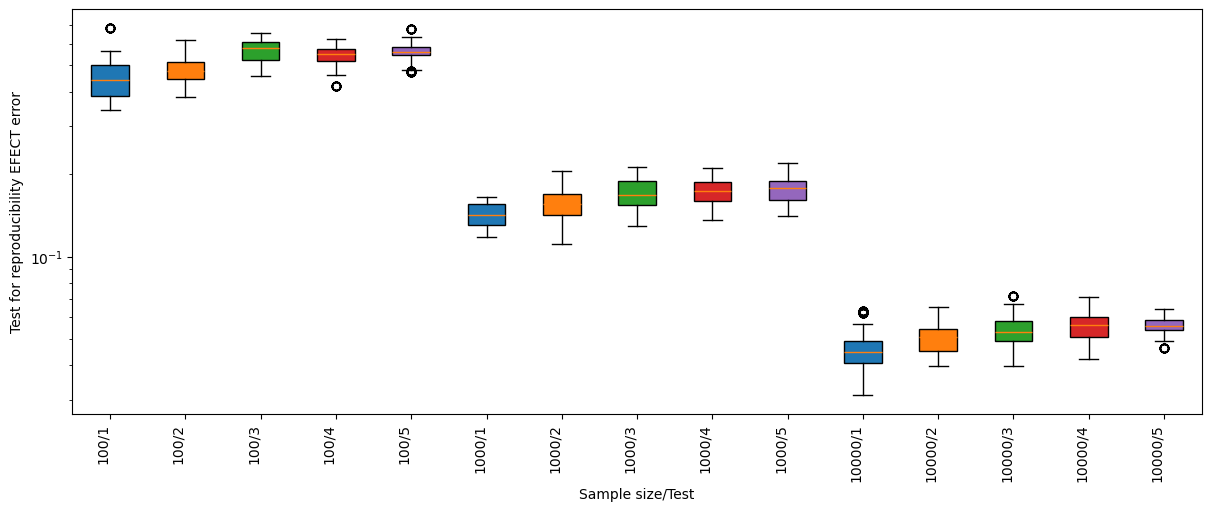

In [9]:
fig_ax = plt.subplots(1, 1, figsize=(12.0, 5.0), layout='compressed')

data = []
labels = []
for t in test_kwargs['trials']:
    for i, test in enumerate(tests):
        data.append(test.ks_stats_sampling[t])
        labels.append(f'{t}/{i+1}')

bplot = fig_ax[1].boxplot(data, labels=labels, vert=True, patch_artist=True)
fig_ax[1].set_yscale('log')
fig_ax[1].set_xlabel('Sample size/Test')
fig_ax[1].set_ylabel('Test for reproducibility EFECT error')
fig_ax[1].set_xticklabels(fig_ax[1].get_xticklabels(), rotation=90, ha='right')

color_names = list(mcolors.TABLEAU_COLORS)
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(color_names[i % len(tests)])

In [10]:
for i in range(len(tests)):
    fp = f'proto_compare_var_2_{i+1}.json'
    print('Saving output:', fp)
    tests[i].save(fp)
fp_summary = 'proto_compare_var_2_inputs.json'
print('Outputting summary:', fp_summary)
with open(fp_summary, 'w') as f:
    output_data = dict(
        beta_mean=beta_mean,
        beta_stdevs={f'proto_compare_var_2_{i+1}.json': beta_stdevs[i] for i in range(len(tests))}
    )
    json.dump(output_data, f, indent=4)

Saving output: proto_compare_var_2_1.json


Saving output: proto_compare_var_2_2.json


Saving output: proto_compare_var_2_3.json


Saving output: proto_compare_var_2_4.json


Saving output: proto_compare_var_2_5.json


Outputting summary: proto_compare_var_2_inputs.json
